In [218]:
using Interact
using GeometryTypes
using FixedSizeArrays
using LCMGL
using AffineTransforms
using SpatialFields
using ForwardDiff
using PyPlot

In [6]:
import DrakeVisualizer

In [231]:
include("arms.jl")

Arms

In [232]:
include("depth_sensors.jl")

DepthSensors

In [233]:
arm = Arms.two_link_arm();
vis = DrakeVisualizer.Visualizer()
model = DrakeVisualizer.load(vis, arm);

In [234]:
sensor = DepthSensors.Kinect(48,48);
camera_origin = tformtranslate([1;0;2]) * tformrotate([pi;0;0])
LCMGLClient("sensor_rays") do lcmgl
    color(lcmgl, 0, 1, 0)
    begin_mode(lcmgl, LCMGL.LINES)
    for ray in sensor.rays
        vertex(lcmgl, camera_origin.offset...)
        vertex(lcmgl, (camera_origin.offset + camera_origin.scalefwd * convert(Vector, ray))...)
    end
    end_mode(lcmgl)
    switch_buffer(lcmgl)
end

In [235]:
function raycast_arm(x1, x2)
    origins = Arms.link_origins(arm, [x1; x2])
    DrakeVisualizer.draw(model, origins)
    skin = Arms.skin(arm, [x1; x2])
    DrakeVisualizer.load(vis, DrakeVisualizer.GeometryData(convert(GeometryTypes.HomogenousMesh, skin)), 2)
    
    points = DepthSensors.raycast_points(skin, sensor, camera_origin)
    LCMGLClient("raycast") do lcmgl
        color(lcmgl, 0, 1, 0)
        point_size(lcmgl, 5)
        begin_mode(lcmgl, LCMGL.POINTS)
        for point in points
            vertex(lcmgl, convert(Vector, point)...)
        end
        end_mode(lcmgl)
        switch_buffer(lcmgl)
    end
    points
end

raycast_arm (generic function with 1 method)

In [236]:

@manipulate for x1 = linspace(-pi, pi, 101), x2 = linspace(-pi, pi, 101)
    points = raycast_arm(x1, x2)
end;

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"x1",0.0,linspace(-3.141592653589793,3.141592653589793,101),true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"x2",0.0,linspace(-3.141592653589793,3.141592653589793,101),true)

In [237]:
function angle_diff(phi1, phi2)
    mod(phi2 - phi1 + pi, 2*pi) - pi;
end

angle_diff (generic function with 1 method)

In [251]:
x_true = [-1; 1.3]

trials = []

for i = 1:100
    errors = []
    xs = []
    
    x_estimated = rand(2) * 2*pi - pi

    sensed_points = raycast_arm(x_true...)

    function cost(x)
        skin = Arms.skin(arm, x)
        return sum(point -> evaluate(skin, point)^2, sensed_points)
    end

    g_cost = ForwardDiff.gradient(cost)
    for i = 1:50
        push!(xs, x_estimated)
        push!(errors, norm(angle_diff(x_estimated, x_true)))
        gi = g_cost(x_estimated)
        if any(isnan, gi)
            @show x_estimated
            error("NaN in gradient")
        end
        x_estimated -= 0.0005 * gi
    end
    push!(trials, (xs, errors))
end

figure()
hold(true)
for (xs, errors) in trials
    plot(1:length(errors), errors)
end
hold(false)

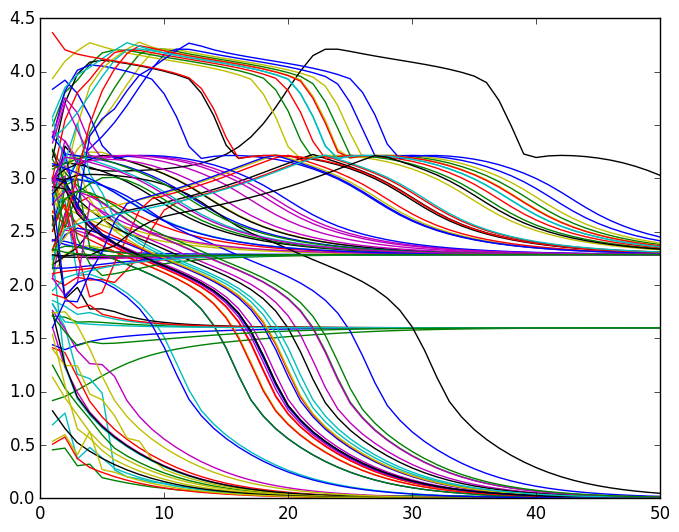

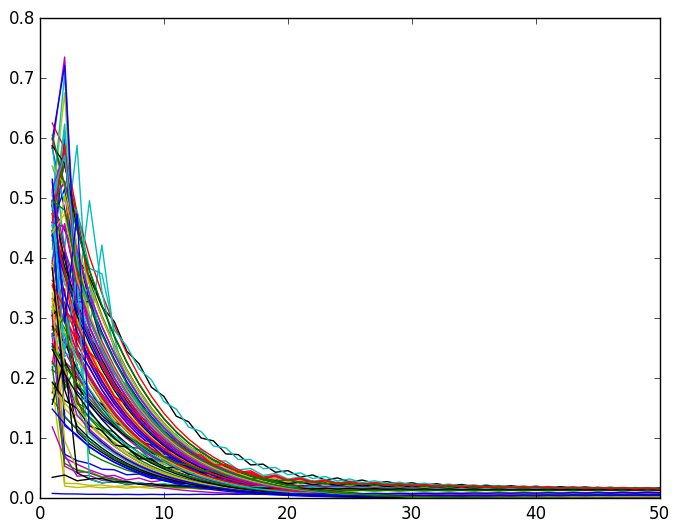

In [253]:
x_true = [-1; 1.3]

trials = []

for i = 1:100
    errors = []
    xs = []
    
    x_estimated = (rand(2) - 0.5) + x_true

    sensed_points = raycast_arm(x_true...)

    function cost(x)
        skin = Arms.skin(arm, x)
        return sum(point -> evaluate(skin, point)^2, sensed_points)
    end

    g_cost = ForwardDiff.gradient(cost)
    for i = 1:50
        push!(xs, x_estimated)
        push!(errors, norm(angle_diff(x_estimated, x_true)))
        gi = g_cost(x_estimated)
        if any(isnan, gi)
            @show x_estimated
            error("NaN in gradient")
        end
        x_estimated -= 0.0005 * gi
    end
    push!(trials, (xs, errors))
end

figure()
hold(true)
for (xs, errors) in trials
    plot(1:length(errors), errors)
end
hold(false)